In [11]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import seaborn as sns

In [12]:
#function to create and print the confusion matrix and the precision recall and F1 scores
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Extinct','Survived']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp+tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Accuracy={0:0.3f}'.format(accuracy))
    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

#function to create the precision- recall curve
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

#function to create the ROC cureve
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
def plot_aucroc(classifier):
    probs = classifier.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [13]:
df = pd.read_csv('mtp_dataset_3_mod.csv')
boring = df[df['life_mode'] == 'boring'].index
df['body_size'] = np.log(df['body_size']) #log transforming body size
df = df.assign(survival_status=df.survival_status.eq('Extinct').astype(int)) #encoding "extinct" as 1 and "survived" as 0
df.drop(['order'], axis = 1, inplace = True) #dropping the column "order"
df.replace('boring', 'infaunal', inplace = True)
df

,lithology,life_mode,motility,feeding_mode,shell_mineralogy,species_richness,ornamentation,environmental_breadth,geographic_range,occurrence,body_size,survival_status
0,mixed,epifaunal,stationary,suspension feeder,aragonite,1,2,2,1,2,3.056486,0
1,siliciclastic,epifaunal,mobile,suspension feeder,aragonite,1,2,4,4,10,4.948570,0
2,siliciclastic,infaunal,mobile,deposit feeder,aragonite,1,2,1,1,1,3.540013,0
3,siliciclastic,infaunal,mobile,deposit feeder,aragonite,4,2,5,4,33,1.085132,0
4,mixed,epifaunal,stationary,suspension feeder,low Mg calcite,3,2,2,6,62,4.377049,0
...,...,...,...,...,...,...,...,...,...,...,...,...
303,siliciclastic,epifaunal,stationary,suspension feeder,aragonite,1,2,1,1,5,3.092152,1
304,siliciclastic,infaunal,stationary,suspension feeder,aragonite,1,2,1,1,1,2.973484,0
305,siliciclastic,infaunal,mobile,suspension feeder,aragonite,3,2,3,2,6,4.261218,1
306,siliciclastic,infaunal,mobile,deposit feeder,aragonite,5,1,4,2,15,3.431797,0


In [14]:
from sklearn.preprocessing import MinMaxScaler #normalises the data

num_cols = ['species_richness', 'ornamentation', 'environmental_breadth', 'geographic_range', 'occurrence', 'body_size']
cat_cols = ['lithology', 'life_mode', 'motility', 'feeding_mode', 'shell_mineralogy']

# apply one-hot encoding on categorical features
df = pd.get_dummies(df, columns = cat_cols)

# apply normalisation on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = MinMaxScaler().fit(df[[i]])
    
    # transform the training data column
    df[i] = scale.transform(df[[i]])

In [15]:
X = df.drop("survival_status", axis=1)
y = df.survival_status

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=27)

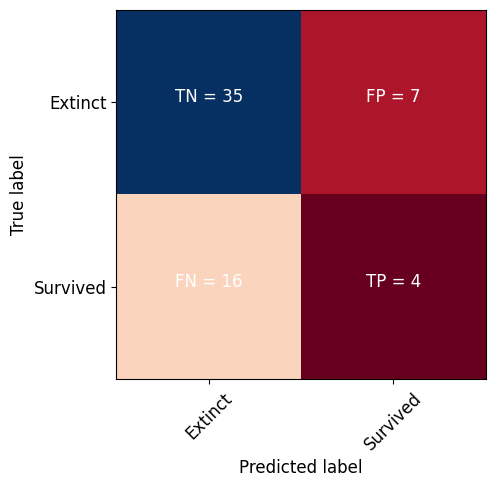

Accuracy=0.629
Recall=0.200 
Precision=0.364
F1=0.258
Average precision-recall score: 0.381


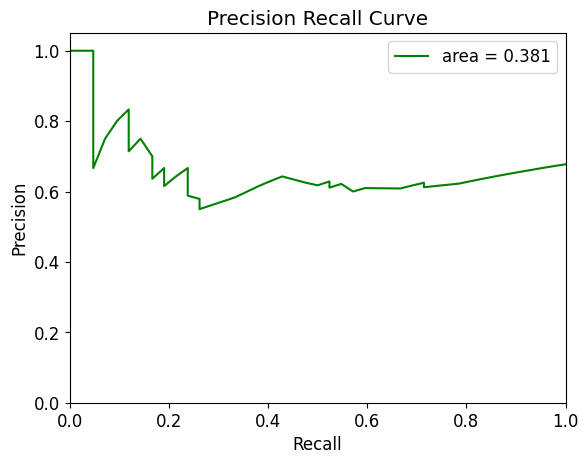

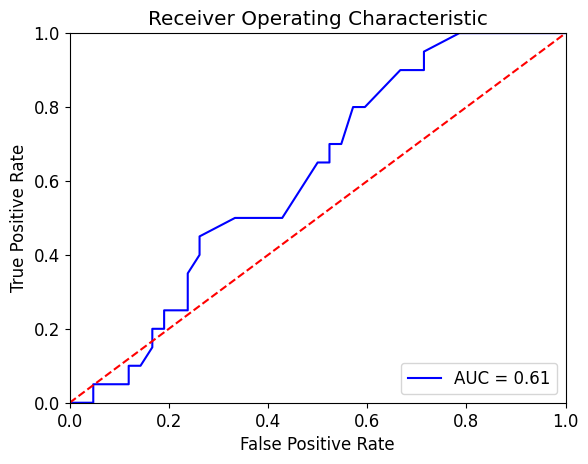

In [17]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42,
                             max_features= 'sqrt', 
                             criterion = 'entropy'
                             )
rfc.fit(X_train, y_train)

#Make predictions
y_pred = rfc.predict(X_test)
try:
    scores = rfc.decision_function(X_test)
except:
    scores = rfc.predict_proba(X_test)[:,1]

#Make plots
plot_cm(rfc, y_pred)
plot_aucprc(rfc, scores)
plot_aucroc(rfc)

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 27)

Classification of SMOTE-resampled dataset with XGboost


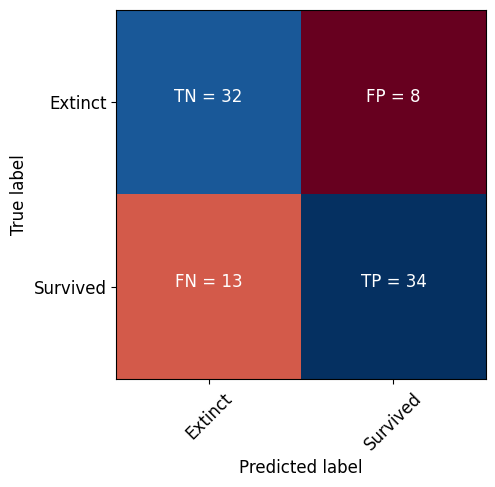

Accuracy=0.759
Recall=0.723 
Precision=0.810
F1=0.764
Average precision-recall score: 0.913


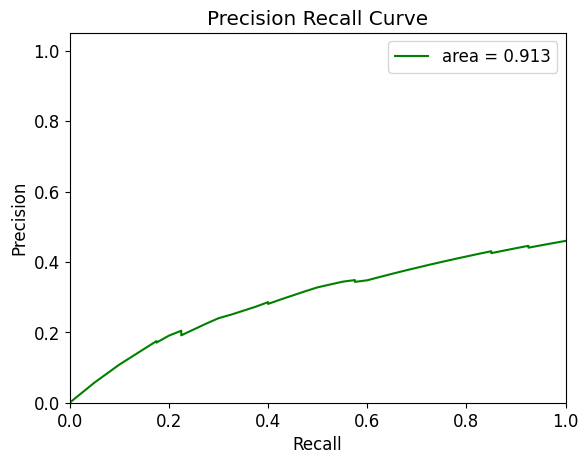

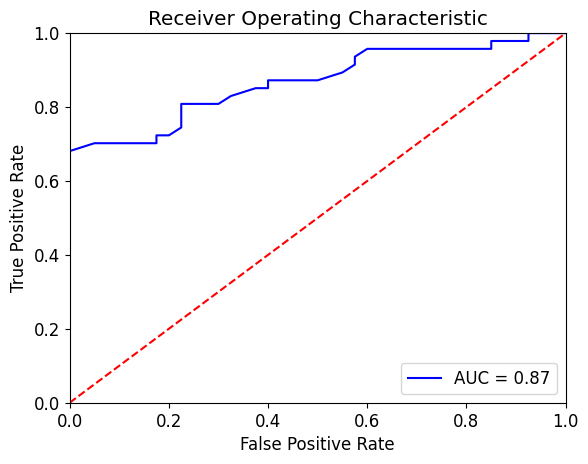

In [19]:
rfc.fit(X_train, y_train)
print('Classification of SMOTE-resampled dataset with XGboost')
from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(n_jobs=-1, random_state = 42,
#                              max_features= 'sqrt', 
#                              criterion = 'entropy'
#                              )
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Make predictions
y_pred = rfc.predict(X_test)
try:
    scores = rfc.decision_function(X_test)
except:
    scores = rfc.predict_proba(X_test)[:,1]

#Make plots
plot_cm(rfc, y_pred)
plot_aucprc(rfc, scores)
plot_aucroc(rfc)

### SHAP

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Using 347 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/87 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature nam

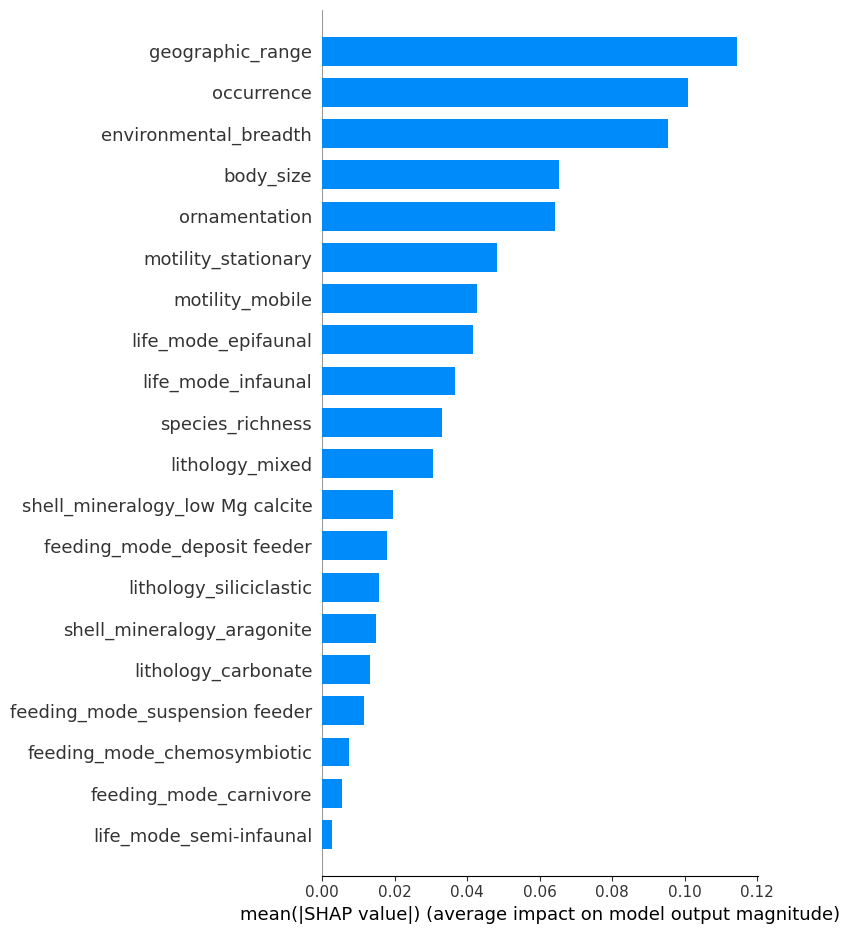

In [20]:
import shap

explainer = shap.KernelExplainer(rfc.predict, X_train)
shap_values = explainer.shap_values(X_test)

features = df.drop(['survival_status'], axis=1).columns.tolist() #not needed for this plot
shap_df = pd.DataFrame(shap_values, columns=pd.Index(features, name='features')) #not needed for this plot

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [21]:
# columns=pd.Index(features, name='features')

# shap_values

In [22]:
group_categorical = {
    'lithology' : 	['lithology_carbonate',
                    'lithology_mixed',
                    'lithology_others',
                    'lithology_siliciclastic'],
    
    'life_mode'	:['life_mode_epifaunal',
                'life_mode_infaunal',
                'life_mode_semi-infaunal'],
    
    'motility' : ['motility_mobile',
                'motility_stationary'],
    
    'feeding_mode' : ['feeding_mode_carnivore',
                    'feeding_mode_chemosymbiotic',
                    'feeding_mode_deposit feeder',
                    'feeding_mode_photosymbiotic',
                    'feeding_mode_suspension feeder'],	
    
    'shell_mineralogy' : ['shell_mineralogy_aragonite',
                        'shell_mineralogy_low Mg calcite'],

    'species_richness' : ['species_richness'],
    
    'ornamentation'	: ['ornamentation'],
    
    'environmental_breadth' : ['environmental_breadth'],	
    
    'geographic_range' : ['geographic_range'],	
    
    'occurrence' : ['occurrence'],

    'body_size' : ['body_size']
}

In [23]:
from itertools import repeat, chain
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

map = revert_dict(group_categorical)

In [24]:
def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

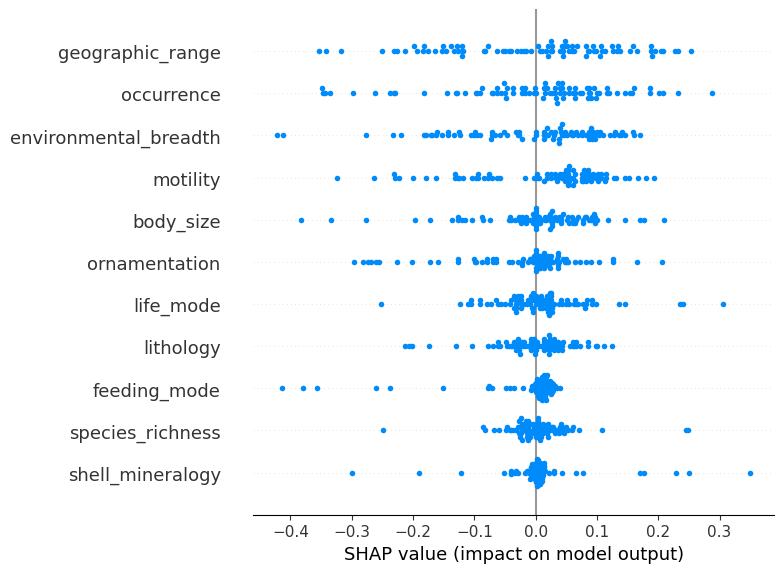

In [25]:
shap_type = grouped_shap(shap_values, features, group_categorical)
shap.summary_plot(shap_type.values, features=shap_type.columns)

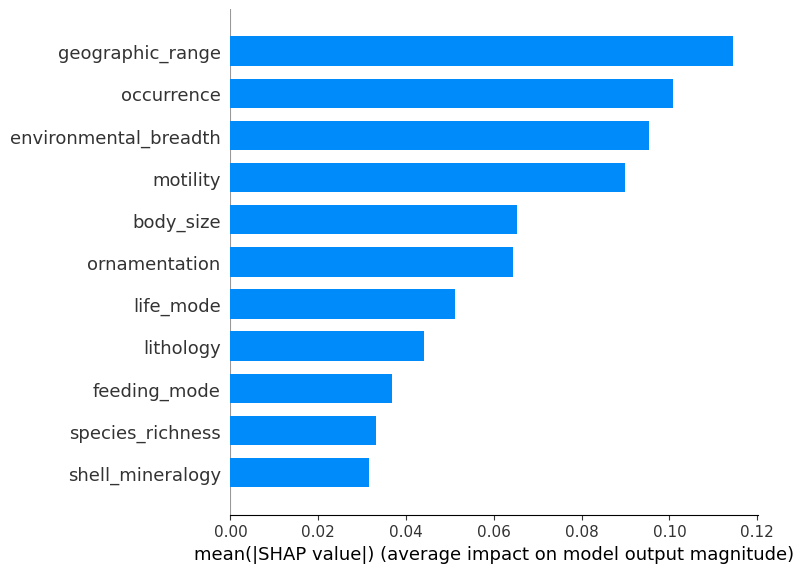

In [26]:
shap.summary_plot(shap_type.values, features=shap_type.columns, plot_type="bar")